AIM:

Reduce number of attributes required to explain descriptions

# Import

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display
from pprint import pprint
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline

# Read

In [2]:
df=pd.read_csv('X_new.csv')

In [3]:
df.head()

heart  vintage  bag  box  glass  christmas  design  candle  flower  holder  \
0      1        0    0    0      0          0       0       0       0       1   
1      0        0    0    0      0          0       0       0       0       0   
2      1        0    0    0      0          0       0       0       0       0   
3      0        0    0    0      0          0       0       0       0       0   
4      1        0    0    0      0          0       0       0       0       0   

   ...  pick  naughts  blueberry  fondant  chrome  sil't  squ  czech  \
0  ...     0        0          0        0       0      0    0      0   
1  ...     0        0          0        0       0      0    0      0   
2  ...     0        0          0        0       0      0    0      0   
3  ...     0        0          0        0       0      0    0      0   
4  ...     0        0          0        0       0      0    0      0   

   puncture  country  
0         0        0  
1         0        0  
2         0        0  
3         0        0  
4         0        0  

[5 rows x 1336 columns]

In [5]:
df.shape

(3627, 1336)

# Automation class

In [6]:
dict_model_info={}

In [7]:
class automation():
    def __init__(self,df):
        '''
        df should be a dataframe having columns as word and rows representing description
        '''
        self.df=df
        self.data=self.df.values
        
        self.model_pca_init=""
        self.model_pca=""
        
        self.df_explainedVar=""
        self.data_transformed=""
        self.df_transformed=""
        
        # models
        self.model_Kmeans=""
        self.model_Spectral=""
        self.model_GaussianMix=""
        self.model_Kmodes=""
        self.model_Agglomerative=""
        
        # labels
        self.labels_Kmeans=""
        self.labels_Spectral=""
        self.labels_GaussianMix=""
        self.labels_Kmodes=""
        self.labels_Agglomerative=""
            
    def modifyData(self,logg=False,normalise=True,v=True):
        '''
        modifies the data of self
        
        logg: 
            applies log(x+userProvidedNumber) to the data
            userProvidedNumber is introduced to get rid of log(0), provided data is non-negative
        
        normalise:
            normalises data with either min max scalar or standard scalar
        '''
        print("in modify Data with: ")
        
        if logg:
            print("\nApplying log") if v else None
            trans_value=int(input("------Enter translation value for log: "))
            print("Previous data:\n",self.data)
            self.data=np.log(self.data+trans_value)
            print("New data:\n",self.data)
            
            print("Done\n") if v else None
        
        if normalise:
            print("\nNormalizing") if v else None
            print("1. min max scalar")
            print("2. standard scalar")
            choice=int(input("------choose: "))
            print("Previous data:\n",self.data)
            if choice==1:
                from sklearn import preprocessing
                min_max_scalar = preprocessing.MinMaxScaler()
                self.data=min_max_scalar.fit_transform(self.data)
            if choice==2:
                from sklearn import preprocessing
                std_scalar = preprocessing.StandardScaler()
                self.data=std_scalar.fit_transform(self.data)
            print("\nNew data",self.data)
            print("Done\n") if v else None
            
            
    def doPCA_initial(self,v=True):
        '''
        does PCA on all the columns of self data
        plots the graph of cummulative explained variance
        and shows info about it
        '''
        print("\nIn PCA initial")
        from sklearn.decomposition import PCA
        self.model_pca_init = PCA(n_components=self.data.shape[1])
        self.model_pca_init.fit(self.data)
        cumSum=self.model_pca_init.explained_variance_ratio_.cumsum()*100
        self.df_explainedVar=pd.DataFrame({'number of dimensions':list(range(self.data.shape[1]+1))[1:],'CumSumEV':list(cumSum)})
        print("Explained variance per dimension: ")
        
        print("Plotting figure") if v else None
        plt.figure(figsize=(14,9))
        plt.plot(cumSum)
        plt.title("Cummulative Explained Variance VS number of dimensions")
        plt.xlabel("Number of dimensions")
        plt.ylabel("Cummulative EV")
        plt.grid()
        plt.show()
        print("Done\n") if v else None
        
        print("Top:")
        display(self.df_explainedVar.head(10))
        print("Bottom:")
        display(self.df_explainedVar.tail(10))
        print("Quartiles")
        display(self.df_explainedVar.describe().loc[['25%','50%','75%']])
        
        self.number_dim_PCA=int(input("------Enter number of dimensions: "))
        print("{} dimensions has cummulative explained variance of {}".
              format(self.number_dim_PCA,cumSum[self.number_dim_PCA-1]))
        
        expvar=float(input("\n------Enter percentage of cummulative explained variance: "))
        for i, ev in enumerate(cumSum):
            if ev >= expvar:
                print("{} dimensions are needed to explain around {} % of variance.".format(i,expvar))
                break

        
    def doPCA(self,v=True):
        '''
        this is performed after we know what dimensions explain how much variance
        
        after PCA, it saves the transformed data in self.data_transformed, self.df_transformed
        saves the model in self.model_pca
        '''
        print("\nApplying PCA") if v else None
        from sklearn.decomposition import PCA
        self.number_dim_PCA=int(input("------Enter number of dimensions: "))
        self.model_pca = PCA(n_components=self.number_dim_PCA)
        
        print("Fitting") if v else None
        self.model_pca.fit(self.data)
        
        print("Transforming data") if v else None
        self.data_transformed = self.model_pca.transform(self.data)
        self.df_transformed=pd.DataFrame(self.data_transformed,\
                                         columns=['dim_{}'.format(i) for i in range(self.number_dim_PCA)])
        print("Transformed data: ")
        display(self.df_transformed.head())
        print("Done\n") if v else None
    
    def applyKmeans(self, Kdata):
        '''
        Appyies Kmeans on the Kdata provided
        saves the labels in self.labels_Kmeans
        saves the model in self.model_Kmeans
        '''
        print("\nApplying Kmeans:")
        from sklearn.cluster import KMeans

        print("Plotting the graph of inertia")
        sse = []
        for K in range(2, 10):
            self.model_Kmeans = KMeans(n_clusters=K,init='k-means++')
            self.model_Kmeans.fit(Kdata)
            sse.append(self.model_Kmeans.inertia_)
            
            from sklearn.metrics import silhouette_samples, silhouette_score
            score=silhouette_score(Kdata,self.model_Kmeans.labels_)
            print("silhouette_score for {} clusters is {}".format(K,score))

        plt.figure(figsize=(10,5))
        plt.title("Inertia plot")
        plt.xlabel("number of clusters")
        plt.ylabel("Inertia")
        plt.plot(list(range(2,10)),sse)
        plt.grid()
        plt.show()

        n_clusters=int(input("------Enter number of clusters: "))

        self.model_Kmeans = KMeans(n_clusters=n_clusters,init='k-means++',verbose=0)

        self.model_Kmeans.fit(Kdata)

        print("\nLabels: \n",self.model_Kmeans.labels_)
        self.labels_Kmeans=self.model_Kmeans.labels_
   
    def applyGaussianMixture(self,Gdata):
        '''
        Appylies Gaussian mixture alg on the Gdata provided
        saves the labels in self.labels_GaussianMix
        saves the model in self.model_GaussianMix
        '''
        print("\nApplying Gaissian Mixture")
        from sklearn import mixture
        n_components=int(input("------Enter number of clusters: "))
        self.model_GaussianMix = mixture.GaussianMixture(n_components=n_components, covariance_type='full')
        self.model_GaussianMix.fit(Gdata)
        self.labels_GaussianMix=self.model_GaussianMix.labels_
        
        print("Labels: ",self.labels_GaussianMix)
    
    def applySpectralClustering(self,Sdata):
        '''
        Appylies Spectral clustering on the Sdata provided
        saves the labels in self.labels_Spectral
        saves the model in self.model_Spectral
        '''
        print("\nApplying Spectral Clustering")
        from sklearn import cluster
        n_clusters=int(input("------Enter number of clusters:"))
        self.model_Spectral = cluster.SpectralClustering(n_clusters=n_clusters,\
                                              eigen_solver='arpack',\
                                              affinity="nearest_neighbors")
        self.model_Spectral.fit(Sdata)
        self.labels_Spectral=self.model_Spectral.labels_
    
        print("Labels: ",self.labels_Spectral)
        
    def applyKmodes(self,KMdata):
        print("\nApplying Kmodes")
        from kmodes.kmodes import KModes
        n_clusters=int(input("------Enter number of clusters:"))
        self.model_Kmodes = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=1)
        self.labels_Kmodes = self.model_Kmodes.fit_predict(KMdata)
        
        print("Labels: ",self.labels_Kmodes)
        
    def applyAgglomerative(self, Adata):
        print("\nApplying Agglomerative clustering")
        from sklearn.cluster import AgglomerativeClustering
        n_clusters=int(input("------Enter number of clusters:"))
        self.model_Agglomerative = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')

        self.labels_Agglomerative= self.model_Agglomerative.fit_predict(X_new.iloc[:,:-2])

        print("Labels: ",self.labels_Agglomerative)

# Initial PCA


In PCA initial
Explained variance per dimension: 
Plotting figure


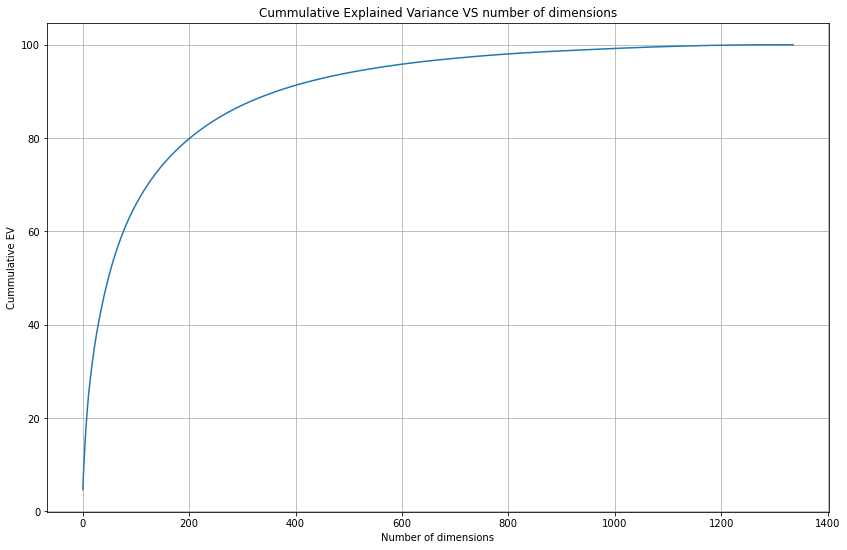

Done

Top:


number of dimensions   CumSumEV
0                     1   4.685049
1                     2   7.708050
2                     3  10.069323
3                     4  12.267165
4                     5  14.383916
5                     6  16.377899
6                     7  18.154457
7                     8  19.734421
8                     9  21.241559
9                    10  22.706421

Bottom:


number of dimensions  CumSumEV
1326                  1327     100.0
1327                  1328     100.0
1328                  1329     100.0
1329                  1330     100.0
1330                  1331     100.0
1331                  1332     100.0
1332                  1333     100.0
1333                  1334     100.0
1334                  1335     100.0
1335                  1336     100.0

Quartiles


number of dimensions   CumSumEV
25%                334.75  88.749291
50%                668.50  96.753915
75%               1002.25  99.224399

------Enter number of dimensions: 6
6 dimensions has cummulative explained variance of 16.377898928339313

------Enter percentage of cummulative explained variance: 99
957 dimensions are needed to explain around 99.0 % of variance.


In [8]:
aut=automation(df)
aut.doPCA_initial()

# Main PCA

## PCA With 6 dimensions for visualization

### Log: F norm: F

in modify Data with: 

Applying PCA
------Enter number of dimensions: 6
Fitting
Transforming data
Transformed data: 


dim_0     dim_1     dim_2     dim_3     dim_4     dim_5
0  1.799906  0.460587 -0.077197 -0.160491 -0.888736  1.527103
1 -0.150437 -0.099986 -0.087519  0.067816 -0.083611  0.027361
2  1.550959 -0.087624  0.063060  0.055265  0.175911 -0.107272
3 -0.159021 -0.087094 -0.057010 -0.051357 -0.064449 -0.032549
4  1.523208 -0.047901  0.068087  0.064241  0.167629 -0.100463

Done



array([[<AxesSubplot:xlabel='dim_0', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_1', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_2', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_3', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_4', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_5', ylabel='dim_0'>],
       [<AxesSubplot:xlabel='dim_0', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_1', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_2', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_3', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_4', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_5', ylabel='dim_1'>],
       [<AxesSubplot:xlabel='dim_0', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_1', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_2', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_3', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_4', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_5', ylabel='dim_2'>],
       [<AxesSubplot:xlab

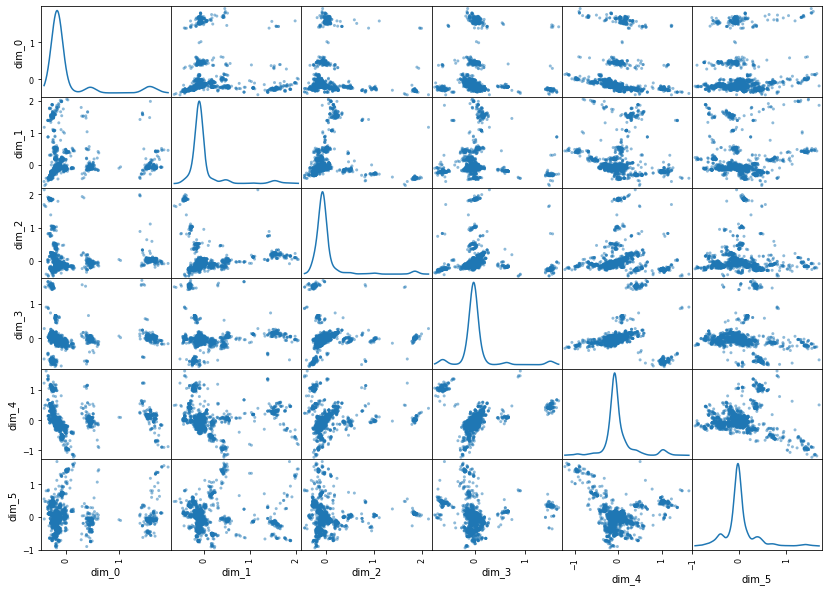

In [9]:
aut1=automation(df)
aut1.modifyData(logg=False,normalise=False)
aut1.doPCA()

pd.plotting.scatter_matrix(aut1.df_transformed,figsize=(14,10),diagonal='kde')

$\color{red}{\text{Obs}}$ 

Clusters are visible

Expected number of clusters seems to be 3 or 4

### Log: T norm: F

in modify Data with: 

Applying log
------Enter translation value for log: 1
Previous data:
 [[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
New data:
 [[0.69314718 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.69314718 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Done


Applying PCA
------Enter number of dimensions: 6
Fitting
Transforming data
Transformed data: 


dim_0     dim_1     dim_2     dim_3     dim_4     dim_5
0  1.247600  0.319200 -0.053207 -0.110695 -0.617558  1.058500
1 -0.104275 -0.069324 -0.060655  0.046999 -0.058007  0.018600
2  1.075043 -0.060738  0.043761  0.038283  0.121766 -0.074313
3 -0.110225 -0.060371 -0.039532 -0.035617 -0.044664 -0.022655
4  1.055807 -0.033201  0.047166  0.044480  0.116305 -0.069635

Done



array([[<AxesSubplot:xlabel='dim_0', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_1', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_2', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_3', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_4', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_5', ylabel='dim_0'>],
       [<AxesSubplot:xlabel='dim_0', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_1', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_2', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_3', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_4', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_5', ylabel='dim_1'>],
       [<AxesSubplot:xlabel='dim_0', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_1', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_2', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_3', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_4', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_5', ylabel='dim_2'>],
       [<AxesSubplot:xlab

<Figure size 1008x648 with 0 Axes>

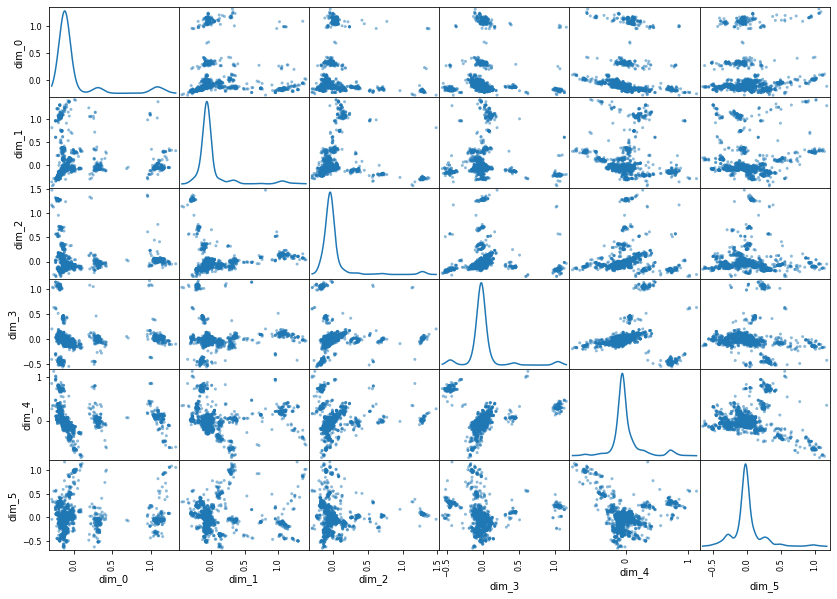

In [106]:
aut2=automation(df)
aut2.modifyData(logg=True,normalise=False)
aut2.doPCA()

pd.plotting.scatter_matrix(aut2.df_transformed,figsize=(14,10),diagonal='kde')

$\color{red}{\text{Obs}}$ 

Applying log is having no effect as the original data is binary

### Log: F norm: T (standard scalar)

in modify Data with: 

Normalizing
1. min max scalar
2. standard scalar
------choose: 2
Previous data:
 [[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

New data [[ 3.47762316 -0.23511863 -0.22447932 ... -0.01660681 -0.01660681
  -0.01660681]
 [-0.28755272 -0.23511863 -0.22447932 ... -0.01660681 -0.01660681
  -0.01660681]
 [ 3.47762316 -0.23511863 -0.22447932 ... -0.01660681 -0.01660681
  -0.01660681]
 ...
 [-0.28755272 -0.23511863 -0.22447932 ... -0.01660681 -0.01660681
  -0.01660681]
 [-0.28755272 -0.23511863 -0.22447932 ... -0.01660681 -0.01660681
  -0.01660681]
 [-0.28755272 -0.23511863 -0.22447932 ... -0.01660681 -0.01660681
  -0.01660681]]
Done


Applying PCA
------Enter number of dimensions: 6
Fitting
Transforming data
Transformed data: 


dim_0     dim_1     dim_2     dim_3     dim_4     dim_5
0  2.085164 -7.659352  3.670138  0.057836  2.446381 -0.535225
1 -0.473136 -0.265691  0.094069  0.161899 -0.164894  0.016018
2 -0.253389 -2.946170  1.571323  2.222585  0.299900  1.005916
3 -0.971793 -0.056933 -0.555315  0.475898 -0.997453  0.090214
4  0.990491 -2.203384  1.293326  1.493391  0.483299  0.158610

Done



array([[<AxesSubplot:xlabel='dim_0', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_1', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_2', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_3', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_4', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_5', ylabel='dim_0'>],
       [<AxesSubplot:xlabel='dim_0', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_1', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_2', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_3', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_4', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_5', ylabel='dim_1'>],
       [<AxesSubplot:xlabel='dim_0', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_1', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_2', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_3', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_4', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_5', ylabel='dim_2'>],
       [<AxesSubplot:xlab

<Figure size 1008x648 with 0 Axes>

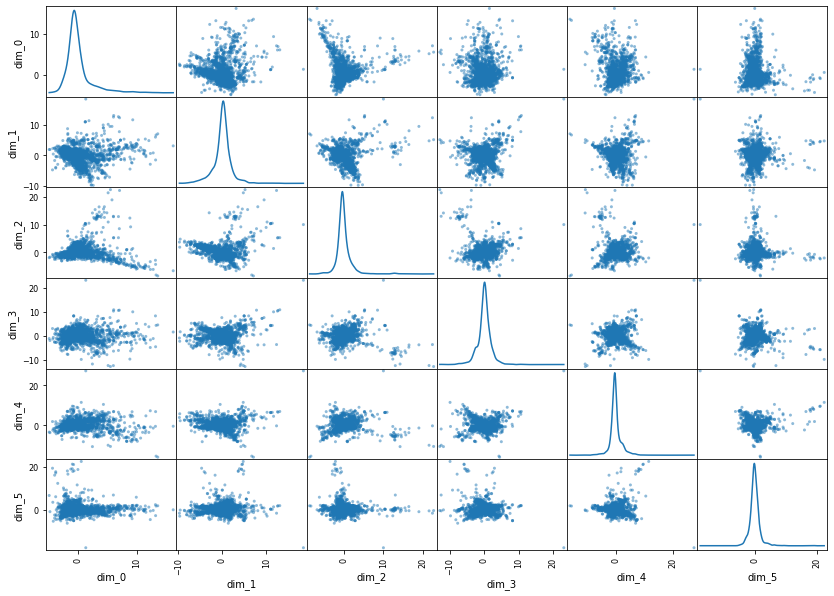

In [108]:
aut3=automation(df)
aut3.modifyData(logg=False,normalise=True)
aut3.doPCA()

pd.plotting.scatter_matrix(aut3.df_transformed,figsize=(14,10),diagonal='kde')

$\color{red}{\text{Obs}}$ 

As the data were binary, no outliers were there and all columns were having same range

hence after applying standard scalar, the clusters are no longer visible

### Log: F norm: T (min max)

in modify Data with: 

Normalizing
1. min max scalar
2. standard scalar
------choose: 1
Previous data:
 [[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

New data [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Done


Applying PCA
------Enter number of dimensions: 6
Fitting
Transforming data
Transformed data: 


dim_0     dim_1     dim_2     dim_3     dim_4     dim_5
0  1.799906  0.460487 -0.076510 -0.160205 -0.891088  1.526534
1 -0.150438 -0.100010 -0.087494  0.067983 -0.084100  0.027153
2  1.550959 -0.087618  0.063098  0.055173  0.175696 -0.107004
3 -0.159021 -0.087094 -0.057057 -0.051364 -0.064488 -0.032571
4  1.523208 -0.047894  0.068051  0.064178  0.167788 -0.100475

Done



array([[<AxesSubplot:xlabel='dim_0', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_1', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_2', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_3', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_4', ylabel='dim_0'>,
        <AxesSubplot:xlabel='dim_5', ylabel='dim_0'>],
       [<AxesSubplot:xlabel='dim_0', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_1', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_2', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_3', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_4', ylabel='dim_1'>,
        <AxesSubplot:xlabel='dim_5', ylabel='dim_1'>],
       [<AxesSubplot:xlabel='dim_0', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_1', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_2', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_3', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_4', ylabel='dim_2'>,
        <AxesSubplot:xlabel='dim_5', ylabel='dim_2'>],
       [<AxesSubplot:xlab

<Figure size 1008x648 with 0 Axes>

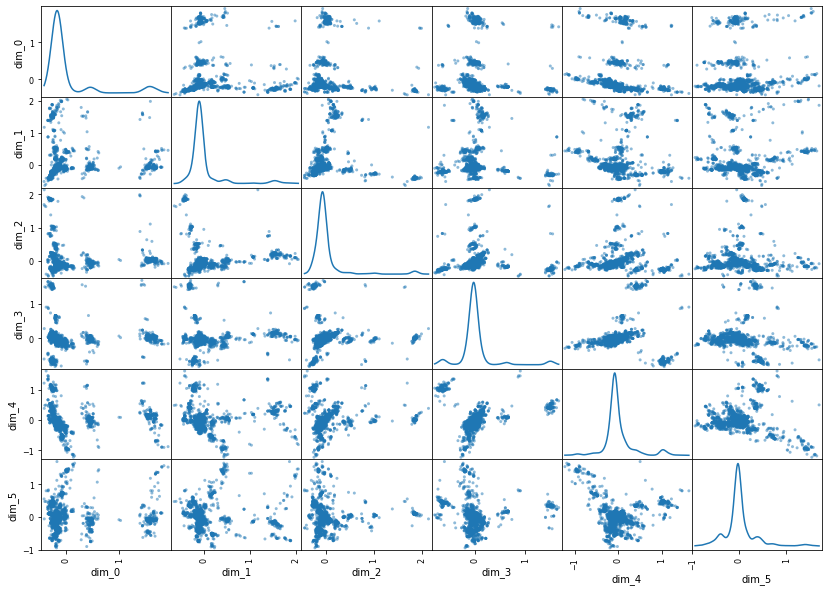

In [109]:
aut4=automation(df)
aut4.modifyData(logg=False,normalise=True)
aut4.doPCA()

pd.plotting.scatter_matrix(aut4.df_transformed,figsize=(14,10),diagonal='kde')

$\color{red}{\text{Obs}}$

Since the data are binary, applying min max scalar had no effect on it

### Kmeans 1

choose number of clusters given by the silhoute score


Applying Kmeans:
Plotting the graph of inertia
silhouette_score for 2 clusters is 0.587846455494655
silhouette_score for 3 clusters is 0.6155318583258355
silhouette_score for 4 clusters is 0.6417803153973097
silhouette_score for 5 clusters is 0.6532372769573734
silhouette_score for 6 clusters is 0.6888705533812186
silhouette_score for 7 clusters is 0.7048939632959437
silhouette_score for 8 clusters is 0.5261480859457044
silhouette_score for 9 clusters is 0.56027630052673


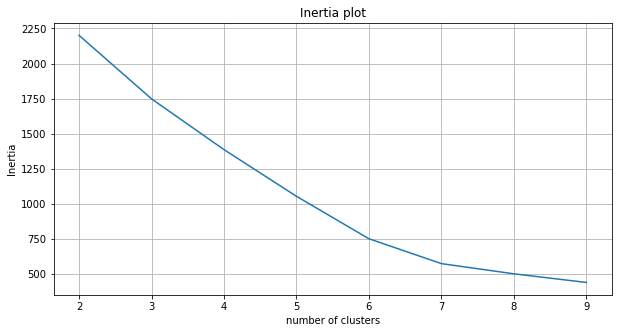

------Enter number of clusters: 7

Labels: 
 [4 0 1 ... 0 0 0]


In [10]:
aut1.applyKmeans(aut1.data_transformed)

In [14]:
dict_model_info['NLP_Kmeans_p6c7']=(aut1.labels_Kmeans,\
                                     silhouette_score(aut1.data_transformed,aut1.labels_Kmeans))

In [15]:
dict_model_info

{'NLP_Kmeans_p6c7': (array([4, 0, 1, ..., 0, 0, 0]), 0.7048939632959437)}

#### Viz

In [16]:
import plotly.express as px
fig = px.scatter_matrix(
    aut1.data_transformed,
    title="Clusters obtained from Kmeans",
    opacity=0.8,
    color=aut1.labels_Kmeans
)
fig.show()

$\color{red}{\text{Obs}}$

The colors are overlapping, unable to visualize clusters

In [17]:
import plotly.express as px

fig = px.scatter_3d(
    aut1.df_transformed, x='dim_0', y='dim_1', z='dim_2',
    title="Clusters shown by first 3 dimensions",
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},\
    opacity=1,
    color=aut1.labels_Kmeans
)
fig.show()

$\color{red}{\text{Obs}}$

the first 3 principal components are unable to explain clusters

### Kmeans 2

choose number of clusters to be 3


Applying Kmeans:
Plotting the graph of inertia
silhouette_score for 2 clusters is 0.587846455494655
silhouette_score for 3 clusters is 0.6155318583258355
silhouette_score for 4 clusters is 0.6417803153973097
silhouette_score for 5 clusters is 0.6532372769573734
silhouette_score for 6 clusters is 0.6887804328400575
silhouette_score for 7 clusters is 0.7048939632959437
silhouette_score for 8 clusters is 0.5274941966535306
silhouette_score for 9 clusters is 0.5385254154964637


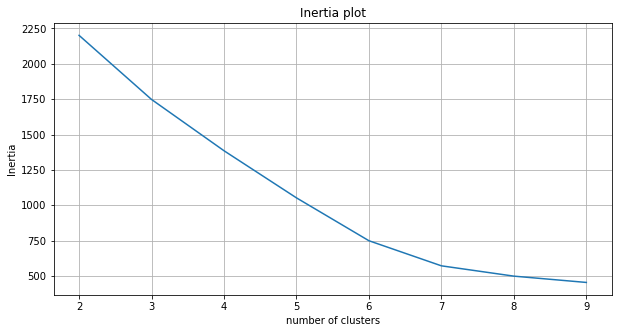

------Enter number of clusters: 3

Labels: 
 [1 2 1 ... 2 2 2]


In [18]:
aut1.applyKmeans(aut1.data_transformed)

In [19]:
dict_model_info['NLP_Kmeans_p6c3']=(aut1.labels_Kmeans,\
                                     silhouette_score(aut1.data_transformed,aut1.labels_Kmeans))

In [20]:
dict_model_info

{'NLP_Kmeans_p6c7': (array([4, 0, 1, ..., 0, 0, 0]), 0.7048939632959437),
 'NLP_Kmeans_p6c3': (array([1, 2, 1, ..., 2, 2, 2]), 0.6155318583258355)}

#### viz

In [220]:
import plotly.express as px
fig = px.scatter_matrix(
    aut1.data_transformed,
    title="Clusters obtained from Kmeans",
    opacity=0.8,
    color=aut1.labels_Kmeans
)
fig.show()

$\color{red}{\text{Obs}}$

The clusters given by NLP and Kmeans are somewhat matching

1) dim0 separates cluster 1 well

2) dim1 separates cluster 2 well

In [221]:
import plotly.express as px

fig = px.scatter_3d(
    aut1.df_transformed, x='dim_0', y='dim_1', z='dim_2',
    title="Clusters shown by first 3 dimensions",
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},\
    opacity=1,
    color=aut1.labels_Kmeans
)
fig.show()

$\color{red}{\text{Obs}}$

The first 3 principal components are explaining the clusters

In [228]:
dict_models_info

{'name': ['NLP_Kmeans_p6c7', 'NLP_Kmeans_p6c3'],
 'score': [0.7154789244099355, 0.6263620262723648],
 'labels': [array([1, 0, 1, ..., 0, 0, 0]), array([1, 0, 1, ..., 0, 0, 0])]}

##  PCA With dimentions explaining 99% variance

In [21]:
but1=automation(df)
but1.modifyData(logg=False,normalise=False)
but1.doPCA()

in modify Data with: 

Applying PCA
------Enter number of dimensions: 955
Fitting
Transforming data
Transformed data: 


dim_0     dim_1     dim_2     dim_3     dim_4     dim_5     dim_6  \
0  1.799906  0.460489 -0.076832 -0.159925 -0.890586  1.526855  0.550087   
1 -0.150437 -0.099998 -0.087544  0.067958 -0.083631  0.027048 -0.154724   
2  1.550959 -0.087622  0.063134  0.055142  0.175699 -0.107169 -0.067731   
3 -0.159021 -0.087093 -0.057038 -0.051394 -0.064445 -0.032631 -0.133712   
4  1.523208 -0.047896  0.068047  0.064191  0.167768 -0.100429 -0.068810   

      dim_7     dim_8     dim_9  ...   dim_945   dim_946   dim_947   dim_948  \
0  0.385788 -0.143447  0.321332  ... -0.000701 -0.002230  0.002548 -0.002816   
1 -0.060645 -0.016170 -0.036719  ... -0.009931  0.003717  0.001268  0.000243   
2 -0.009955 -0.051845 -0.257219  ... -0.004821  0.000236 -0.003232 -0.007684   
3 -0.055630 -0.005314 -0.101903  ... -0.010748 -0.011663 -0.004672 -0.005393   
4  0.009144 -0.054480 -0.199199  ...  0.018922  0.013959 -0.037321  0.002896   

    dim_949   dim_950   dim_951   dim_952   dim_953   dim_954  
0  0.000024 -0.004146  0.005240  0.010183  0.001030  0.005135  
1 -0.003852  0.009940 -0.002106 -0.006204 -0.005988 -0.008468  
2  0.001356 -0.001468  0.002751  0.000017  0.001308 -0.001243  
3  0.000158 -0.014052 -0.002921  0.005656  0.006667 -0.010784  
4  0.010191 -0.001790 -0.031047 -0.009034 -0.011194 -0.006124  

[5 rows x 955 columns]

Done



### Kmeans 1

choose the number of clusters on the basis of silhoutte score


Applying Kmeans:
Plotting the graph of inertia
silhouette_score for 2 clusters is 0.10353268946147229
silhouette_score for 3 clusters is 0.10774307620650427
silhouette_score for 4 clusters is 0.0710043737346986
silhouette_score for 5 clusters is 0.055296579227021816
silhouette_score for 6 clusters is 0.06853637825498521
silhouette_score for 7 clusters is 0.07969023218599643
silhouette_score for 8 clusters is 0.06848873368510766
silhouette_score for 9 clusters is 0.04942461025872454


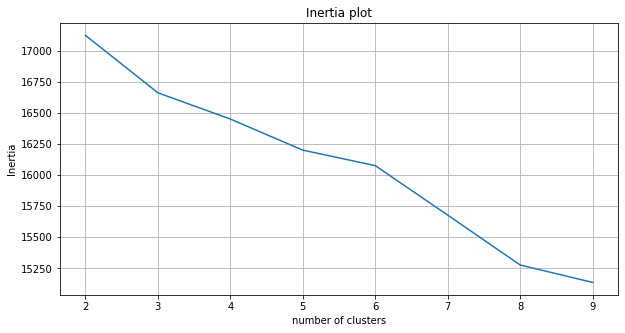

------Enter number of clusters: 3

Labels: 
 [0 2 0 ... 2 2 2]


In [55]:
but1.applyKmeans(but1.data_transformed)

In [24]:
dict_model_info['NLP_Kmeans_p955c3']=(but1.labels_Kmeans,\
                                     silhouette_score(but1.data_transformed,but1.labels_Kmeans))

In [25]:
dict_model_info

{'NLP_Kmeans_p6c7': (array([4, 0, 1, ..., 0, 0, 0]), 0.7048939632959437),
 'NLP_Kmeans_p6c3': (array([1, 2, 1, ..., 2, 2, 2]), 0.6155318583258355),
 'NLP_Kmeans_p955c3': (array([1, 0, 1, ..., 0, 0, 0]), 0.10774307620650427)}

# Get meaning of clusters

In [26]:
df.head(2)

heart  vintage  bag  box  glass  christmas  design  candle  flower  holder  \
0      1        0    0    0      0          0       0       0       0       1   
1      0        0    0    0      0          0       0       0       0       0   

   ...  pick  naughts  blueberry  fondant  chrome  sil't  squ  czech  \
0  ...     0        0          0        0       0      0    0      0   
1  ...     0        0          0        0       0      0    0      0   

   puncture  country  
0         0        0  
1         0        0  

[2 rows x 1336 columns]

In [27]:
# word count
df.iloc[:,:-1].sum(axis=0)

heart       277
vintage     190
bag         174
box         151
glass       157
           ... 
chrome        2
sil't         1
squ          20
czech         1
puncture      1
Length: 1335, dtype: int64

## Size of each cluster

In [28]:
for name, tup in dict_model_info.items():
    print(name)
    print(pd.Series(tup[0]).value_counts())
    print("Score: ",tup[1])
    print("")

NLP_Kmeans_p6c7
0    2665
1     253
2     175
5     165
4     129
3     125
6     115
dtype: int64
Score:  0.7048939632959437

NLP_Kmeans_p6c3
2    3173
1     272
0     182
dtype: int64
Score:  0.6155318583258355

NLP_Kmeans_p955c3
0    3179
1     272
2     176
dtype: int64
Score:  0.10774307620650427



## Pre-processing

In [29]:
for name, tup in dict_model_info.items():
    df[name]=tup[0]

In [31]:
df.head(3)

heart  vintage  bag  box  glass  christmas  design  candle  flower  holder  \
0      1        0    0    0      0          0       0       0       0       1   
1      0        0    0    0      0          0       0       0       0       0   
2      1        0    0    0      0          0       0       0       0       0   

   ...  fondant  chrome  sil't  squ  czech  puncture  country  \
0  ...        0       0      0    0      0         0        0   
1  ...        0       0      0    0      0         0        0   
2  ...        0       0      0    0      0         0        0   

   NLP_Kmeans_p6c7  NLP_Kmeans_p6c3  NLP_Kmeans_p955c3  
0                4                1                  1  
1                0                2                  0  
2                1                1                  1  

[3 rows x 1339 columns]

In [32]:
df_org=pd.read_csv('pure_placedOrders_new.csv')

In [33]:
df_org.head(2)

InvoiceNo StockCode                         Description  \
0     536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER   
1     536365     71053                 WHITE METAL LANTERN   

           InvoiceDate  UnitPrice  CustomerID         Country  FinalQuantity  
0  2010-12-01 08:26:00       2.55       17850  United Kingdom              6  
1  2010-12-01 08:26:00       3.39       17850  United Kingdom              6

In [34]:
list_UniqueDesc=list(df_org['Description'].unique())

In [35]:
list_UniqueDesc[:5]

['WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE METAL LANTERN',
 'CREAM CUPID HEARTS COAT HANGER',
 'KNITTED UNION FLAG HOT WATER BOTTLE',
 'RED WOOLLY HOTTIE WHITE HEART.']

In [39]:
for name,tup in dict_model_info.items():
    corresp = dict()
    for key, val in zip (list_UniqueDesc,list(tup[0])):
        corresp[key] = val 
    df_org[name] =df_org.loc[:, 'Description'].map(corresp)

In [40]:
corresp

{'WHITE HANGING HEART T-LIGHT HOLDER': 1,
 'WHITE METAL LANTERN': 0,
 'CREAM CUPID HEARTS COAT HANGER': 1,
 'KNITTED UNION FLAG HOT WATER BOTTLE': 0,
 'RED WOOLLY HOTTIE WHITE HEART.': 1,
 'SET 7 BABUSHKA NESTING BOXES': 0,
 'GLASS STAR FROSTED T-LIGHT HOLDER': 2,
 'HAND WARMER UNION JACK': 0,
 'ASSORTED COLOUR BIRD ORNAMENT': 0,
 "POPPY'S PLAYHOUSE BEDROOM ": 0,
 "POPPY'S PLAYHOUSE KITCHEN": 0,
 'FELTCRAFT PRINCESS CHARLOTTE DOLL': 0,
 'IVORY KNITTED MUG COSY ': 0,
 'BOX OF 6 ASSORTED COLOUR TEASPOONS': 0,
 'BOX OF VINTAGE JIGSAW BLOCKS ': 0,
 'BOX OF VINTAGE ALPHABET BLOCKS': 0,
 'HOME BUILDING BLOCK WORD': 0,
 'LOVE BUILDING BLOCK WORD': 0,
 'RECIPE BOX WITH METAL HEART': 1,
 'DOORMAT NEW ENGLAND': 0,
 'JAM MAKING SET WITH JARS': 0,
 'RED COAT RACK PARIS FASHION': 0,
 'YELLOW COAT RACK PARIS FASHION': 0,
 'BLUE COAT RACK PARIS FASHION': 0,
 'BATH BUILDING BLOCK WORD': 0,
 'ALARM CLOCK BAKELIKE PINK': 0,
 'ALARM CLOCK BAKELIKE RED ': 0,
 'ALARM CLOCK BAKELIKE GREEN': 0,
 'PANDA AND B

In [43]:
df_org.head(2)

InvoiceNo StockCode                         Description  \
0     536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER   
1     536365     71053                 WHITE METAL LANTERN   

           InvoiceDate  UnitPrice  CustomerID         Country  FinalQuantity  \
0  2010-12-01 08:26:00       2.55       17850  United Kingdom              6   
1  2010-12-01 08:26:00       3.39       17850  United Kingdom              6   

   NLP_Kmeans_p6c7  NLP_Kmeans_p6c3  NLP_Kmeans_p955c3  
0                4                1                  1  
1                0                2                  0

In [44]:
pure_Labels_NLP=df_org.copy(deep=True)
pure_Labels_NLP.to_csv('pure_Labels_NLP.csv',index=False)

$\color{red}{\text{Do}}$

Select one label

selct NLP_Kmeans_p955c3

Reason: 3 clusters are easier to explain

we had used 955 rows, which were explaining 99% of cummulative variance

## Words in each cluster

In [47]:
toDrop=list(dict_model_info.keys())

In [49]:
for clusterNo in np.unique(but1.labels_Kmeans):
    print("Cluster {}".format(clusterNo))
    group=df.groupby('NLP_Kmeans_p955c3')
    
    # see the words which are there in the descriptions in given cluster
    clusterGroup=group.get_group(clusterNo).drop(toDrop,axis=1)
    #display(clusterGroup)
    print("size of the cluster: ",clusterGroup.shape[0])
    fil=clusterGroup.sum()>0
    #print(fil)
    print("The word in it: ")
    print(clusterGroup.columns[fil])
    print("")

Cluster 0
size of the cluster:  3179
The word in it: 
Index(['vintage', 'bag', 'box', 'christmas', 'design', 'candle', 'flower',
       'holder', 'decorative', 'metal',
       ...
       'pick', 'naughts', 'blueberry', 'fondant', 'chrome', 'sil't', 'squ',
       'czech', 'puncture', 'country'],
      dtype='object', length=1287)

Cluster 1
size of the cluster:  272
The word in it: 
Index(['heart', 'vintage', 'bag', 'box', 'glass', 'christmas', 'design',
       'candle', 'flower', 'holder',
       ...
       'quartz', 'braclet', 'hold', 'mid', 'handle', 'charge', 'bonheur',
       'carry', 'stop', 'carrier'],
      dtype='object', length=296)

Cluster 2
size of the cluster:  176
The word in it: 
Index(['heart', 'vintage', 'bag', 'glass', 'christmas', 'design', 'candle',
       'flower', 'holder', 'metal',
       ...
       'hold', 'mid', 'perfume', 'elixir', 'songbird', 'tonic', 'hexagon',
       'stop', 'chrome', 'squ'],
      dtype='object', length=228)



## Descriptions in each cluster

In [53]:
df_Labels=pd.read_csv('pure_Labels_NLP.csv')

list_UniqueDesc=list(df_Labels['Description'].unique())

df.index=list_UniqueDesc

for clusterNo in np.unique(df['NLP_Kmeans_p955c3'].unique()):
    print("Cluster {}".format(clusterNo))
    group=df.groupby('NLP_Kmeans_p955c3')
    
    # descriptions in given cluster
    clusterGroup=group.get_group(clusterNo).drop(toDrop,axis=1)
    #display(clusterGroup)
    print("size of the cluster: ",clusterGroup.shape[0])
    print(clusterGroup.index[0:40])
    print("")

Cluster 0
size of the cluster:  3179
Index(['WHITE METAL LANTERN', 'KNITTED UNION FLAG HOT WATER BOTTLE',
       'SET 7 BABUSHKA NESTING BOXES', 'HAND WARMER UNION JACK',
       'ASSORTED COLOUR BIRD ORNAMENT', 'POPPY'S PLAYHOUSE BEDROOM ',
       'POPPY'S PLAYHOUSE KITCHEN', 'FELTCRAFT PRINCESS CHARLOTTE DOLL',
       'IVORY KNITTED MUG COSY ', 'BOX OF 6 ASSORTED COLOUR TEASPOONS',
       'BOX OF VINTAGE JIGSAW BLOCKS ', 'BOX OF VINTAGE ALPHABET BLOCKS',
       'HOME BUILDING BLOCK WORD', 'LOVE BUILDING BLOCK WORD',
       'DOORMAT NEW ENGLAND', 'JAM MAKING SET WITH JARS',
       'RED COAT RACK PARIS FASHION', 'YELLOW COAT RACK PARIS FASHION',
       'BLUE COAT RACK PARIS FASHION', 'BATH BUILDING BLOCK WORD',
       'ALARM CLOCK BAKELIKE PINK', 'ALARM CLOCK BAKELIKE RED ',
       'ALARM CLOCK BAKELIKE GREEN', 'PANDA AND BUNNIES STICKER SHEET',
       'STARS GIFT TAPE ', 'INFLATABLE POLITICAL GLOBE ',
       'VINTAGE HEADS AND TAILS CARD GAME ', 'SET/2 RED RETROSPOT TEA TOWELS ',
     

$\color{red}{\text{Obs}}$

cluster 0 contains $\bf{\text{Home or Personal Accessories}}$

cluster 1 contains $\bf{\text{Gift Items}}$

cluster 2 contains $\bf{\text{Kitchen Materials}}$

## Top words for ecach cluster

In [54]:
for clusterNo in np.unique(df['NLP_Kmeans_p955c3'].unique()):
    print("Cluster {}".format(clusterNo))
    group=df.groupby('NLP_Kmeans_p955c3')
    
    # descriptions in given cluster
    clusterGroup=group.get_group(clusterNo).drop(toDrop,axis=1)
    #display(clusterGroup)
    print("size of the cluster: ",clusterGroup.shape[0])
    display(pd.DataFrame(clusterGroup.sum(),columns=['count']).\
    sort_values(by='count',ascending=False).\
    head(10))

Cluster 0
size of the cluster:  3179


count
pin        286
vint       183
vintage    180
sign       178
pot        169
bag        161
box        144
ring       143
candle     140
flowe      133

Cluster 1
size of the cluster:  272


count
ear           272
art           272
heart         270
gin            32
sweet          31
dec            31
deco           30
sweetheart     29
pin            27
hanging        27

Cluster 2
size of the cluster:  176


count
ass         176
las         176
glass       156
bracelet     24
class        21
neckl        20
hold         20
holder       20
light        18
jar          18